<a href="https://colab.research.google.com/github/JatinMoolchandani2002/alzheimer-s_disease_prediction-/blob/main/AD_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

In [ ]:
!unzip /content/drive/MyDrive/Alzheimer/AD_MRI_2.zip

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

In [ ]:
def data_gen(data):
  x_data = []
  y_data = []
  train_path = os.path.join('/content/Alzheimer_s Dataset', data)
  os.listdir(train_path)
  for folder in os.listdir(train_path):
    image_path = os.path.join(train_path, folder)
    for image in os.listdir(image_path):
      if(folder == 'MildDemented'):
        image = np.array(Image.open(os.path.join(image_path, image)).resize((224, 224)))
        x_data.append(image)
        y_data.append(2)
      if(folder == 'ModerateDemented'):
        image = np.array(Image.open(os.path.join(image_path, image)).resize((224, 224)))
        x_data.append(image)
        y_data.append(3)
      if(folder == 'NonDemented'):
        image = np.array(Image.open(os.path.join(image_path, image)).resize((224, 224)))
        x_data.append(image)
        y_data.append(0)
      if(folder == 'VeryMildDemented'):
        image = np.array(Image.open(os.path.join(image_path, image)).resize((224, 224)))
        x_data.append(image)
        y_data.append(1)
  return x_data, y_data

In [ ]:
x_train_data, y_train_data = data_gen('train')

X = np.array(x_train_data).reshape(-1, 224, 224, 1)/255.0
Y = np.array(y_train_data).reshape(-1,1)

In [ ]:
onehotencoder = OneHotEncoder()
onehot_Y = onehotencoder.fit_transform(Y).toarray()

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, onehot_Y, test_size=0.25, random_state=4)

In [ ]:
input = tf.keras.Input(shape=(224, 224, 1), name='input')
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='conv1')(input)
x = tf.keras.layers.MaxPooling2D(name='maxPool1')(x)
x = tf.keras.layers.BatchNormalization(name='batchNorm1')(x) #(112 * 112 * 64)
X = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', name='conv2')(x)
x = tf.keras.layers.MaxPooling2D(name='maxPool2')(x)
x = tf.keras.layers.BatchNormalization(name='batchNorm2')(x) #(56 * 56 * 32)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', name='conv3')(x)
x = tf.keras.layers.MaxPooling2D(name='maxPool3')(x)
x = tf.keras.layers.BatchNormalization(name='batchNorm3')(x) #(28 * 56 * 32)
x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', name='conv4')(x)
x = tf.keras.layers.MaxPooling2D(name='maxPool4')(x)
x = tf.keras.layers.BatchNormalization(name='batchNorm4')(x) #(14 * 14 * 16)
x = tf.keras.layers.Dropout(0.2, name='dropout1')(x)
x = tf.keras.layers.Flatten(name='flatten')(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-4), name='dense1')(x)
output = tf.keras.layers.Dense(4, activation='softmax', name='output')(x)

In [ ]:
model = tf.keras.Model(inputs=input, outputs=output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 1)]     0         
                                                                 
 conv1 (Conv2D)              (None, 224, 224, 64)      640       
                                                                 
 maxPool1 (MaxPooling2D)     (None, 112, 112, 64)      0         
                                                                 
 batchNorm1 (BatchNormalizat  (None, 112, 112, 64)     256       
 ion)                                                            
                                                                 
 maxPool2 (MaxPooling2D)     (None, 56, 56, 64)        0         
                                                                 
 batchNorm2 (BatchNormalizat  (None, 56, 56, 64)       256       
 ion)                                                        

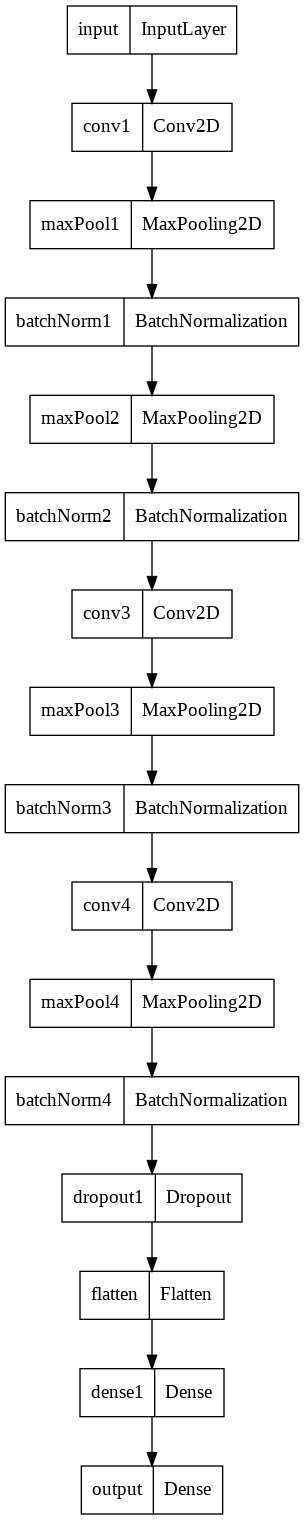

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
epochs = 50
batch_size = 16
initial_learning_rate = 6e-4
final_learning_rate = 6e-5
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(x_train.shape[0]/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

In [ ]:
class callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epochs, logs={}):
    if(logs['val_accuracy']>0.99 and logs['val_loss']<0.07):
      print(f'\nStopping training as model val accuracy is {logs["val_accuracy"]} and val loss is {logs["val_loss"]}\n"')
      self.model.stop_training = True

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate = 6e-4),
              metrics = ['accuracy'])

In [ ]:
# history = model.fit(x_train, y_train, batch_size=16, validation_data=(x_val, y_val), validation_batch_size=4, epochs=50, callbacks=callback())

Epoch 1/50
  5/240 [..............................] - ETA: 6s - loss: 2.1555 - accuracy: 0.4375

240/240 [==============================] - 14s 44ms/step - loss: 0.9514 - accuracy: 0.5901 - val_loss: 1.7386 - val_accuracy: 0.3411
Epoch 2/50
240/240 [==============================] - 10s 42ms/step - loss: 0.7003 - accuracy: 0.6969 - val_loss: 0.8843 - val_accuracy: 0.6011
Epoch 3/50
240/240 [==============================] - 8s 33ms/step - loss: 0.4788 - accuracy: 0.8078 - val_loss: 0.5453 - val_accuracy: 0.7799
Epoch 4/50
240/240 [==============================] - 9s 37ms/step - loss: 0.2980 - accuracy: 0.8961 - val_loss: 0.2900 - val_accuracy: 0.9063
Epoch 5/50
240/240 [==============================] - 8s 33ms/step - loss: 0.1733 - accuracy: 0.9523 - val_loss: 0.3499 - val_accuracy: 0.8774
Epoch 6/50
240/240 [==============================] - 8s 33ms/step - loss: 0.1326 - accuracy: 0.9643 - val_loss: 0.2010 - val_accuracy: 0.9352
Epoch 7/50
240/240 [==============================] - 9s 37ms/step - loss: 0.1192 - accuracy: 0.9688 - val_loss: 0.2445 - val_accuracy: 0.9055
Epoch 8/

In [ ]:
model.predict(np.array(Image.open('/content/Alzheimer_s Dataset/test/MildDemented/26.jpg').resize((224, 224))).reshape(-1, 224,224,1)/255)

1/1 [==============================] - 0s 17ms/step


array([[6.8411026e-03, 2.9032777e-05, 9.9312979e-01, 1.5503454e-11]],
      dtype=float32)

In [ ]:
# model.save('/content/drive/MyDrive/Alzheimer/model_v4.h5')

In [ ]:
X_test, Y_test = data_gen('test')
x_test = np.array(x_train_data).reshape(-1, 224, 224, 1)/255.0
y_test = np.array(y_train_data).reshape(-1,1)
onehot_y_test = onehotencoder.fit_transform(y_test).toarray()

In [ ]:
y_test_pred = model.predict(x_test)

161/161 [==============================] - 3s 20ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
confusion_matrix(y_test.reshape(-1,), np.argmax(y_test_pred, axis = 1))

array([[2555,    2,    3,    0],
       [   3, 1787,    2,    0],
       [   0,    0,  717,    0],
       [   0,    2,    0,   50]])

In [ ]:
print(classification_report(y_test.reshape(-1,), np.argmax(y_test_pred, axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2560
           1       1.00      1.00      1.00      1792
           2       0.99      1.00      1.00       717
           3       1.00      0.96      0.98        52

    accuracy                           1.00      5121
   macro avg       1.00      0.99      0.99      5121
weighted avg       1.00      1.00      1.00      5121



Class : 2 and Confidence : 99.31298065185547%


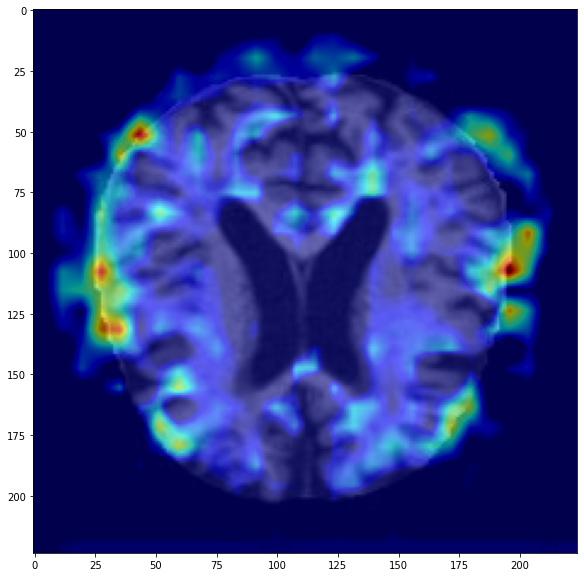

In [ ]:
def gradCam(processed_image):

  layer_name = 'conv4'
  conv_output = model.get_layer(layer_name).output
  gradCamModel = tf.keras.Model(inputs=[model.inputs], outputs=[conv_output, model.output])
  
  cls = 0
  with tf.GradientTape() as tape:
    ConvOutputs, predictions = gradCamModel(processed_image)
    loss = predictions[:, cls]
  grads = tape.gradient(loss, ConvOutputs)
  print(f"Class : {np.argmax(predictions)} and Confidence : {predictions[:, np.argmax(predictions)][0]*100}%")
  output, grads_val = ConvOutputs[0, :], grads[0, :, :, :]
  weights = np.mean(grads_val, axis=(0, 1))
  cam = np.dot(output, weights)

  cam = cv2.resize(cam, (224, 224), cv2.INTER_LINEAR)

  cam = np.maximum(cam, 0)
  cam = cam / cam.max()

  plt.figure(figsize=(10, 10))
  plt.imshow(processed_image.reshape(224, 224), cmap='gray')
  plt.imshow(cam, cmap='jet', alpha = 0.6)
